In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.random.seed(24)

In [5]:
path_test = r'./DailyDelhiClimateTest.csv'
path_train = r'./DailyDelhiClimateTrain.csv'

df_test = pd.read_csv(path_test, parse_dates=True, index_col='date')
df_train = pd.read_csv(path_train, parse_dates=True, index_col='date')

#### Verificando a existência de outliers usando <i>boxplot

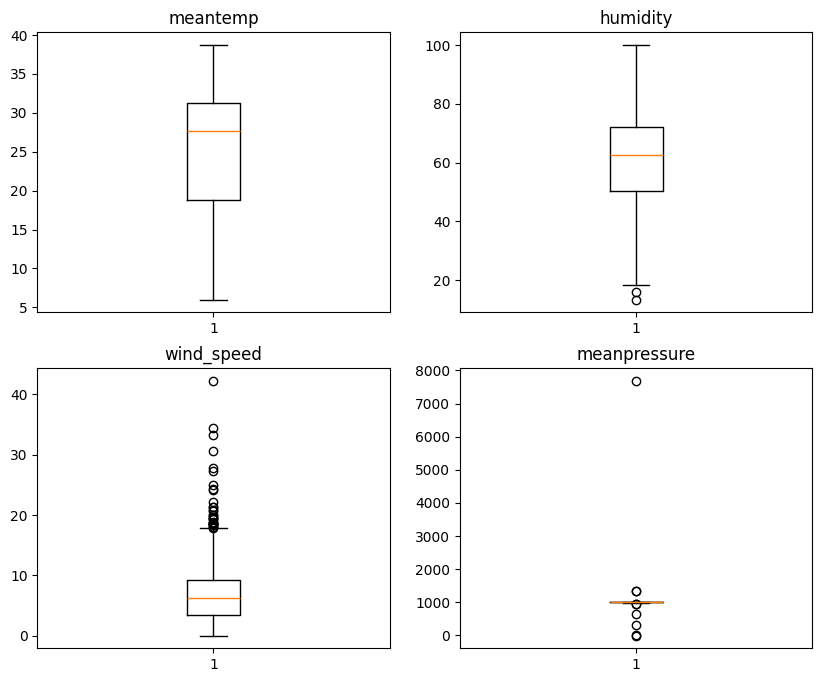

In [14]:
fig, axis = plt.subplots(2, 2, figsize=(10,8))

axis[0, 0].boxplot(df_train[df_train.columns[0]])
axis[0, 0].set_title(f'{df_train.columns[0]}')

axis[0, 1].boxplot(df_train[df_train.columns[1]])
axis[0, 1].set_title(f'{df_train.columns[1]}')

axis[1, 0].boxplot(df_train[df_train.columns[2]])
axis[1, 0].set_title(f'{df_train.columns[2]}')

axis[1, 1].boxplot(df_train[df_train.columns[3]])
axis[1, 1].set_title(f'{df_train.columns[3]}')

plt.show()

#### Vericando os <i>outliers</i> da coluna <b>\['meanpressure']

In [15]:
df_train.loc[(df_train.meanpressure < 950) | (df_train.meanpressure > 1300), 'meanpressure']

date
2016-03-28    7679.333333
2016-06-09     938.066667
2016-07-24     946.312500
2016-08-02     310.437500
2016-08-14     633.900000
2016-08-16      -3.041667
2016-09-24    1352.615385
2016-11-17    1350.296296
2016-11-28      12.045455
Name: meanpressure, dtype: float64

#### Vericando os <i>outliers</i> da coluna <b>\['wind_speed']

In [16]:
df_train.loc[(df_train.wind_speed < 0) | (df_train.wind_speed > 20), 'wind_speed']

date
2013-03-01    24.066667
2013-09-09    42.220000
2013-12-25    34.487500
2014-01-06    27.337500
2014-01-07    20.600000
2014-06-12    24.325000
2014-08-13    20.825000
2014-09-23    30.685714
2014-10-17    25.012500
2014-10-18    21.300000
2015-01-28    27.775000
2015-08-19    33.325000
2016-03-22    22.100000
2016-06-07    21.306250
Name: wind_speed, dtype: float64

#### Eliminando os outliers

In [17]:
df_train = df_train.drop(df_train.loc[(df_train.meanpressure < 980) | (df_train.meanpressure > 1300), 'meanpressure'].index)
df_train = df_train.drop(df_train.loc[(df_train.wind_speed < 0) | (df_train.wind_speed > 17), 'wind_speed'].index)

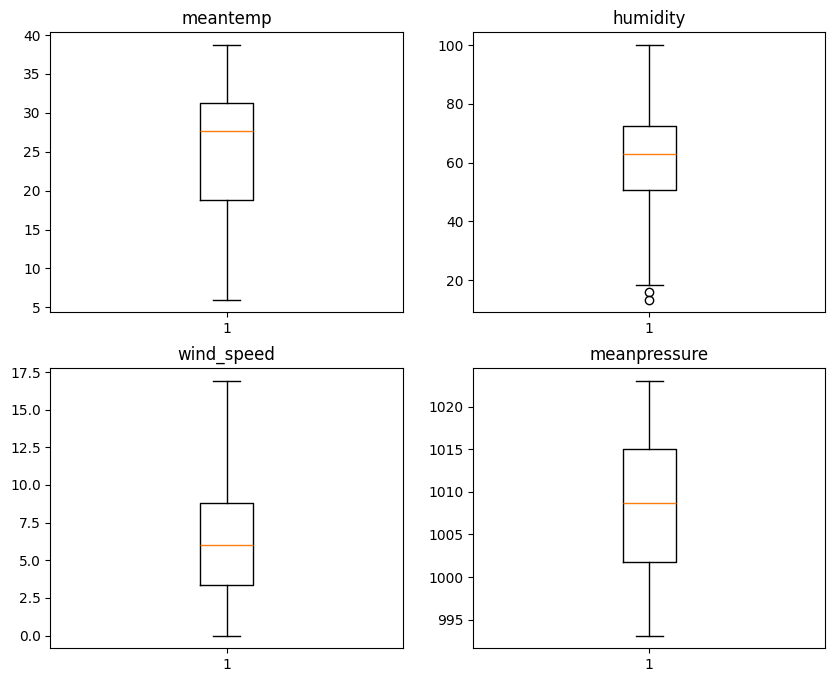

In [20]:
# plt.figure(figsize=(3,2))
fig, axis = plt.subplots(2, 2, figsize=(10,8))

axis[0, 0].boxplot(df_train[df_train.columns[0]])
axis[0, 0].set_title(f'{df_train.columns[0]}')

axis[0, 1].boxplot(df_train[df_train.columns[1]])
axis[0, 1].set_title(f'{df_train.columns[1]}')

axis[1, 0].boxplot(df_train[df_train.columns[2]])
axis[1, 0].set_title(f'{df_train.columns[2]}')

axis[1, 1].boxplot(df_train[df_train.columns[3]])
axis[1, 1].set_title(f'{df_train.columns[3]}')

plt.show()

#### Análise gráfica da série temporal 

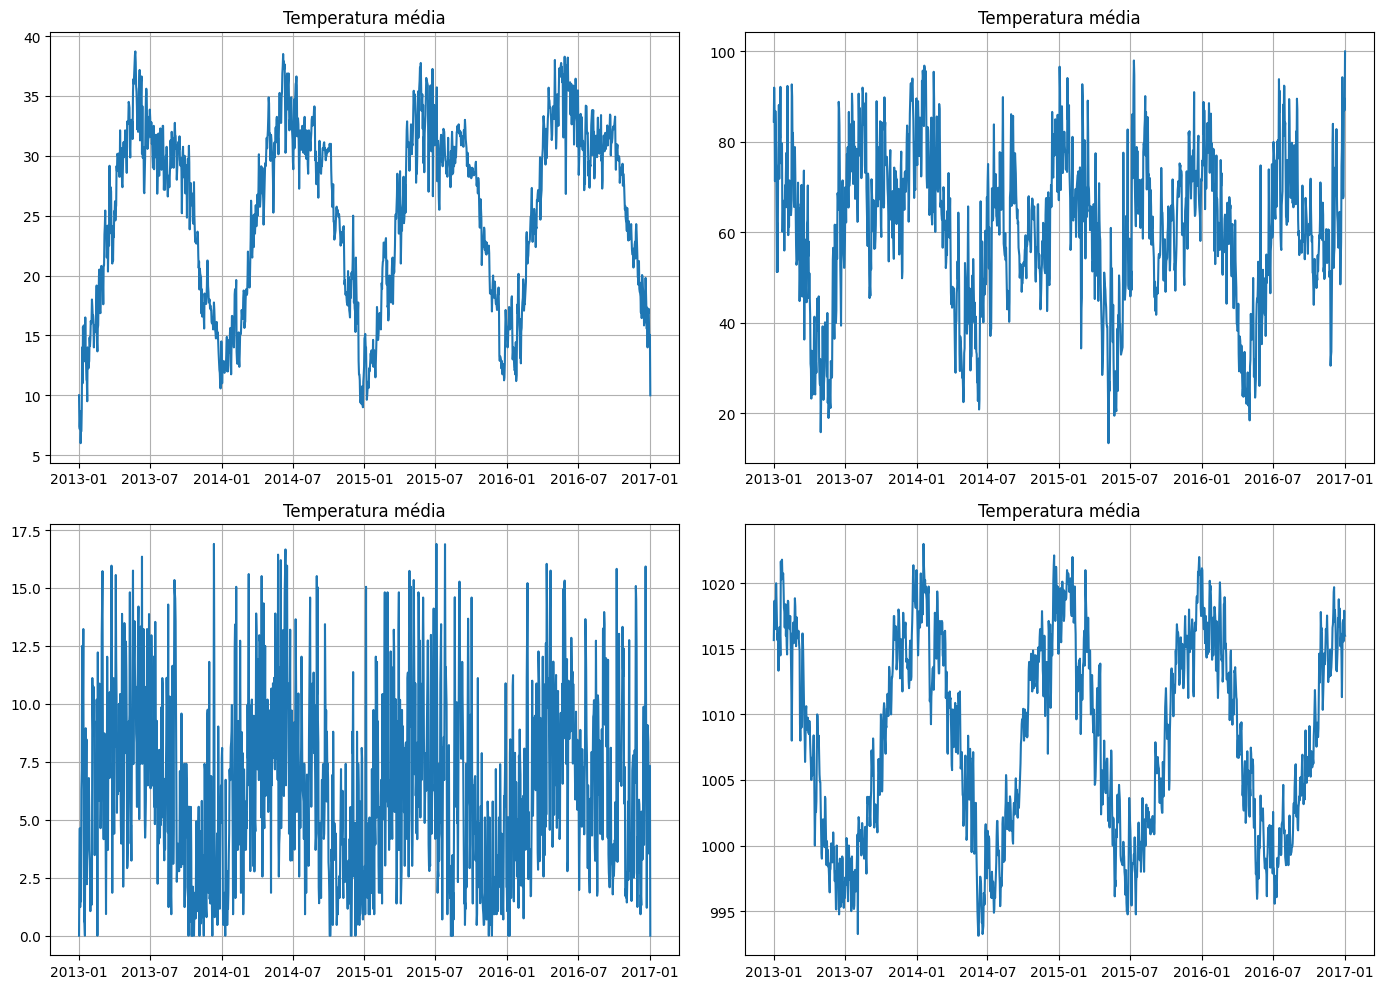

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0,0].plot(df_train[df_train.columns[0]])
ax[0,0].grid()
ax[0,0].set_title('Temperatura média')
# ax[0,0].tick_params(axis='x', rotation=45)

ax[0,1].plot(df_train[df_train.columns[1]])
ax[0,1].grid()
ax[0,1].set_title('Temperatura média')
# ax[0,1].tick_params(axis='x', rotation=45)

ax[1,0].plot(df_train[df_train.columns[2]])
ax[1,0].grid()
ax[1,0].set_title('Temperatura média')
# ax[1,0].tick_params(axis='x', rotation=45)

ax[1,1].plot(df_train[df_train.columns[3]])
ax[1,1].grid()
ax[1,1].set_title('Temperatura média')
# ax[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Pré-processamento dos dados (normalização)

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Separando os recursos (features)
features = df_train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]

# Normalizando os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Criando um DataFrame dos dados normalizados
scaled_data = pd.DataFrame(scaled_features, index=df_train.index, columns=features.columns)

#### Criando sequências para o modelo LSTM

In [91]:
scaled_data

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,0.122271,0.820957,0.000000,0.754533
2013-01-02,0.042795,0.907591,0.176331,0.825941
2013-01-03,0.035662,0.849835,0.274162,0.854951
2013-01-04,0.081514,0.668867,0.072978,0.804742
2013-01-05,0.000000,0.847910,0.218935,0.782427
...,...,...,...,...
2016-12-28,0.342890,0.630865,0.209931,0.751137
2016-12-29,0.282387,0.859736,0.355030,0.795975
2016-12-30,0.247453,0.880638,0.370809,0.829448


In [48]:
from sklearn.model_selection import train_test_split

def create_sequences(data, target_column, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data.iloc[i:i + seq_length].values)  # Sequência de valores das 4 colunas
        y.append(data.iloc[i + seq_length][target_column])  # Valor futuro da variável target (meantemp)
    return np.array(x), np.array(y)


X, y = create_sequences(scaled_data, target_column='meantemp', seq_length=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#### <b> LSTM

In [49]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense,GRU, LSTM, Dropout

In [50]:
model = Sequential()

In [51]:
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=64, return_sequences= True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32))
model.add(Dense(units=16))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 10, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,273 (305.75 KB)

 Trainable params: 78,273 (305.75 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1268
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0075
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065
Epoch 13/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058
Epoch 14/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057
Epoch 15/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058
Epoc

In [235]:
# Previsões com o conjunto de teste
predictions_scaled = model.predict(X_test)

# Desnormalizando as previsões para trazer ao valor original
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, np.zeros((predictions_scaled.shape[0], 3))], axis=1))

# Passando para um dataframe as predições
df_predictions = pd.DataFrame(predictions, index=df_train.index[-predictions.shape[0]:], columns=df_train.columns)

# Desnormalizando os valores reais para comparar
y_test_scaled = scaler.inverse_transform(np.concatenate([ y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3)) ], axis=1))

# Passando para um dataframe os valores reais
df_y_test = pd.DataFrame(y_test_scaled, index=df_train.index[-y_test_scaled.shape[0]:], columns=df_train.columns)



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


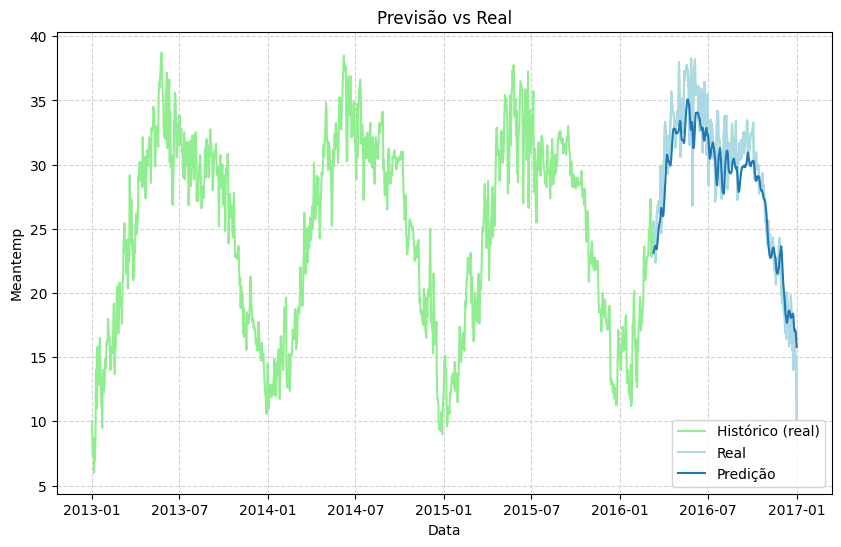

In [257]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df_train.meantemp, label='Histórico (real)', color='lightgreen')
plt.plot(df_y_test.meantemp, label='Real', color='lightblue')
plt.plot(df_predictions.meantemp, label='Predição')
plt.title('Previsão vs Real')
plt.xlabel('Data')
plt.ylabel('Meantemp')
plt.legend()
plt.grid(linestyle='--', color='lightgray')
plt.show()

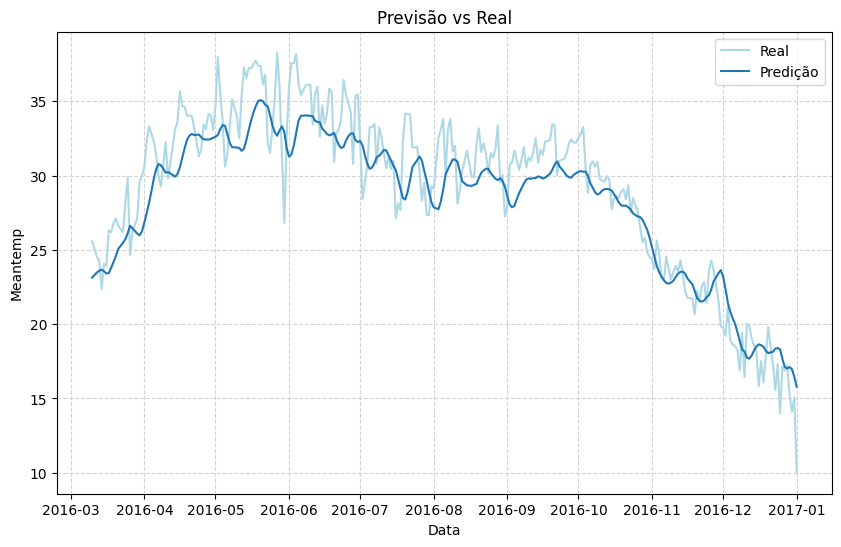

In [252]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df_y_test.meantemp, label='Real', color='lightblue')
plt.plot(df_predictions.meantemp, label='Predição')
plt.title('Previsão vs Real')
plt.xlabel('Data')
plt.ylabel('Meantemp')
plt.legend()
plt.grid(linestyle='--', color='lightgray')
plt.show()